In [1]:
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = '../.datasets/gps_tracks/'
BASIC_FILE = 'matchedData.txt'
TRACK_FILE = 'trackData.npy'
NORMALIZED_FILE = 'normalizedTrackData.npy'
HEADER = 'driverId;vehicleId;travelOrderId;trackerId;distance;description;snapped;timestamps'

In [2]:
### read the data from our basic text file
text_data_file = np.genfromtxt(DATA_DIR + BASIC_FILE, delimiter=';', dtype='U', usecols=(6))
### remove the header
text_data_file = text_data_file[1:]
### check how the data looks
print(text_data_file.shape, '\n' ,text_data_file[:1])

(3364,) 
 [ '[[45.442012786865234, 12.052892684936523], [45.44186782836914, 12.05081558227539], [45.44120407104492, 12.04919147491455], [45.44063949584961, 12.046724319458008], [45.438350677490234, 12.035618782043457], [45.43668746948242, 12.027504920959473], [45.435028076171875, 12.019429206848145], [45.434200286865234, 12.015399932861328], [45.43254470825195, 12.007323265075684], [45.430885314941406, 11.999305725097656], [45.43011474609375, 11.995593070983887], [45.42738342285156, 11.982405662536621], [45.426185607910156, 11.976606369018555], [45.424808502197266, 11.969897270202637], [45.424102783203125, 11.966498374938965], [45.4228630065918, 11.960515022277832], [45.423240661621094, 11.957406044006348], [45.42099380493164, 11.955836296081543], [45.417388916015625, 11.957063674926758], [45.415687561035156, 11.958478927612305], [45.412086486816406, 11.961453437805176], [45.40729522705078, 11.963357925415039], [45.401798248291016, 11.962288856506348], [45.396305084228516, 11.959979057

In [3]:
### prepair an extraction methood, that transforms the string above to a list of numpy arrays
def string_to_list(data):
    new_data = []
    for track in data:
        track = track[2 : len(track) - 2].split('], [')
        new_track = []
        for t in track:
            t = t.split(', ')
            new_track.append(t)
        new_track = np.array(new_track)
        new_data.append(new_track.astype(float))
    return new_data

In [4]:
### save the transformed data to our first support file
tracks = np.array(string_to_list(text_data_file))
np.save(DATA_DIR + TRACK_FILE, tracks)


In [5]:
def getMinMaxValues(data):
    ### methood that returns the min and max values of each column
    minMax = np.zeros((2,2))
    minMax[0,0] = np.finfo('d').max
    minMax[0,1] = np.finfo('d').max
    for array in data:
        #print(array[:,0].shape)
        tempMinMax = np.zeros((2,2))
        tempMinMax[0,0] = np.finfo('d').max
        tempMinMax[0,1] = np.finfo('d').max
        
        tempMinMax[0,0] = np.amin(array[:,0])
        tempMinMax[1,0] = np.amax(array[:,0])
        tempMinMax[0,1] = np.amin(array[:,1])
        tempMinMax[1,1] = np.amax(array[:,1])
        
        #print(tempMinMax[0,0],tempMinMax[1,0],tempMinMax[0,1],tempMinMax[1,1])
        
        for j in range(2):
            # test for min
            if minMax[0,j] > tempMinMax[0,j]:
                minMax[0,j] = tempMinMax[0,j]
            # test for max
            if minMax[1,j] < tempMinMax[1,j]:
                minMax[1,j] = tempMinMax[1,j]
    
    return minMax

def normalize(data, minMax):
    """
    Function that normalizes the generated quadratic function data.
    Parameters:
        - data, (list of np.array of shape (n_of_points, 2))
        - minMax, (np.array) where [0,i] represents the min value and [1,i] represents the max value of column i
    """
    for array in data:
        for i in range(2):
            #print(array.shape)
            array[:,i] = (array[:,i] - minMax[0,i]) 
            array[:,i] = array[:,i] / (minMax[1,i] - minMax[0,i])
    
    return data

In [6]:
### loads tracks if needed
#tracks = np.load(DATA_DIR + TRACK_FILE)

### get the min and max values of all the tracks
minMax = getMinMaxValues(tracks)

### normalize the data
normalized_tracks = normalize(tracks, minMax)

### test normalization
print(getMinMaxValues(normalized_tracks))

### save normalized data
np.save(DATA_DIR + NORMALIZED_FILE, normalized_tracks)

[[ 0.  0.]
 [ 1.  1.]]


In [11]:
def partition_data(data, ts_in, ts_out):
    """
    The methood partitions the "track" data of shape (n_of_tracks, n_of_points_per_track, n_of_dim_per_point) into 
    two datasets of tracks representing the input and output of our model, with length ts_in and ts_out respectively.
    Parameters:
        - data (list of np.array), the dataset to be partitioned, a list np.arrays of shape: 
                                                                            (n_of_points_per_track, n_of_dim_per_point)
        - ts_in (int), length of the needed input dataset
        - ts_out (int), length of the needed output dataset

    NOTE: ts_in + ts_out < n_of_points_per_track
    """
    print(data.shape)
    data_in = []
    data_out = []
    for f in data:
        r = f.shape[0]
        if r >= (ts_in + ts_out):
            for i in range(r//(ts_in + ts_out)):
                new_in = f[i:i + ts_in]
                new_out = f[i + ts_in:i + ts_in + ts_out]    
                data_in.append(new_in)
                data_out.append(new_out)

    data_in = np.array(data_in)
    data_out = np.array(data_out)
    
    return data_in, data_out

In [19]:
### partition the normalized track data to the format we need for our model
### shape: input track length = 15, output track length = 5 
tracks_in, tracks_out = partition_data(normalized_tracks, 15, 5)
#print(tracks_in.shape, tracks_out.shape)
#print(tracks_in, tracks_out)

(3364,)


16414


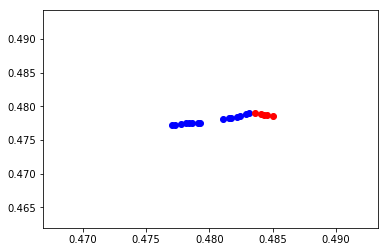

42275


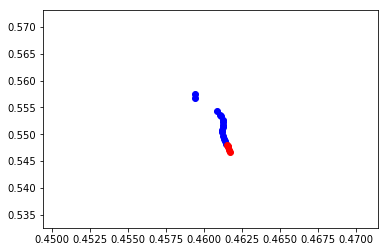

59870


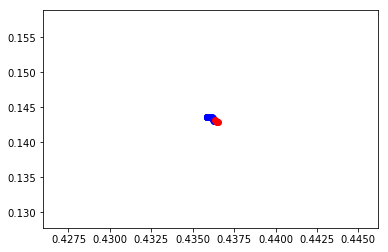

65798


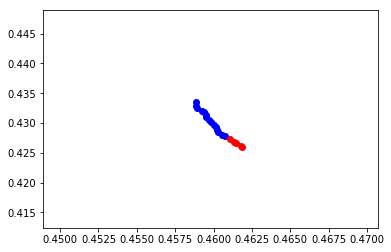

22670


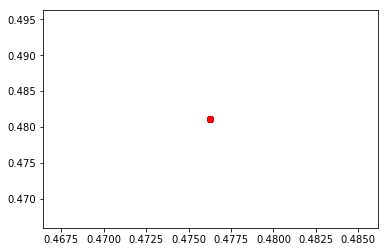

In [29]:
### test the data
for _ in range(5):
    i = np.random.randint(tracks_in.shape[0])
    print(i)
    
    plt.scatter(tracks_in[i,:,0], tracks_in[i,:,1], color='blue')
    plt.scatter(tracks_out[i,:,0], tracks_out[i,:,1], color='red')
    plt.show()

In [38]:
def split_data(data, train_per=0.8, val_per=0.1, test_per=0.1):
    """
    The function splits our dataset over axis=0 into three datasets, training data, validation data and test data.
    Parameters:
        - data (np.array), the dataset to be split,
        - train_per (float), the % of the data to be used for the training set,
        - val_per (float), the % of the data to be used for the validation set,
        - test_per (float), the % of the data to be used for the test set.
    """
        
    train_ind = int(data.shape[0] * train_per)
    val_ind = int(data.shape[0] * (train_per + val_per))
    train_data = data[:train_ind]
    val_data = data[train_ind:val_ind]
    test_data = data[val_ind:]
    
    return train_data, val_data, test_data


In [39]:
### split data into three datasets, train, validation and test data

train_data_in, val_data_in, test_data_in = split_data(tracks_in)
train_data_out, val_data_out, test_data_out = split_data(tracks_out)

### save the preprocessed data
np.save('%strain_data_in.npy' %DATA_DIR, train_data_in)
np.save('%sval_data_in.npy' %DATA_DIR, val_data_in)
np.save('%stest_data_in.npy' %DATA_DIR, test_data_in)

np.save('%strain_data_out.npy' %DATA_DIR, train_data_out)
np.save('%sval_data_out.npy' %DATA_DIR, val_data_out)
np.save('%stest_data_out.npy' %DATA_DIR, test_data_out)

In [2]:
### load the data, if needed


train_data_in = np.load('%strain_data_in.npy' %DATA_DIR)
val_data_in = np.load('%sval_data_in.npy' %DATA_DIR)
test_data_in = np.load('%stest_data_in.npy' %DATA_DIR)

train_data_out = np.load('%strain_data_out.npy' %DATA_DIR)
val_data_out = np.load('%sval_data_out.npy' %DATA_DIR)
test_data_out = np.load('%stest_data_out.npy' %DATA_DIR)



## Define the model

In [3]:
import keras
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector

MODEL_DIR = 'model/'

Using TensorFlow backend.


In [4]:
def seqToSeq_model(n_of_features, input_sequence_length, output_sequence_length):
    
    hidden_neurons = 3000
    model = keras.models.Sequential()

    ##Encoder
    model.add(LSTM(hidden_neurons,
              input_shape=(input_sequence_length, n_of_features),
              return_sequences=False
              ))
    print(model.outputs)
    model.add(Dense(hidden_neurons, activation='relu'))
    model.add(Dropout(0.5))

    print(model.outputs)
    model.add(RepeatVector(output_sequence_length))
    print(model.outputs)
    
    ##Decoder
    model.add(LSTM(hidden_neurons,
              return_sequences=True))

    print(model.outputs)
    model.add(TimeDistributed(Dense(n_of_features, activation='relu')))
    print(model.outputs)

    return model

In [5]:
def load_model(model_dir):
    """
    This function loads a previously traned model from model_dir.
    Parameters:
        - model_dir (string), a directory where the model and its weights are saved.
    """
    try:
        f = open('%smodel' %model_dir, 'r')
        json_string = f.read()

        model = model_from_json(json_string)
        model.load_weights('%sweights' %model_dir)
        print('Model loaded!')

        return model

    except FileNotFoundError:
        print('Could not load model!')


def save_model(model_dir, model):
    """
    This function saves the model to the model_dir directory.
    Properties:
        - model (keras.model), a trained keras model,
        - model_dir (string), the directory to save the model to.
    """
    json_string = model.to_json()

    f = open('%smodel' %model_dir, 'w+')
    f.write(json_string)
    f.close()

    model.save_weights('%sweights' %model_dir)
    print("Model saved!")


In [6]:
MODEL_DIR = 'model/'
model = seqToSeq_model(2, 15, 5)

model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(train_data_in, train_data_out, epochs=5, batch_size=100, validation_data=(val_data_in, val_data_out))

[<tf.Tensor 'lstm_1/TensorArrayReadV3:0' shape=(?, 3000) dtype=float32>]
[<tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 3000) dtype=float32>]
[<tf.Tensor 'repeat_vector_1/Tile:0' shape=(?, 5, 3000) dtype=float32>]
[<tf.Tensor 'lstm_2/transpose_1:0' shape=(?, ?, 3000) dtype=float32>]
[<tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(?, 5, 2) dtype=float32>]
Train on 55350 samples, validate on 6919 samples
Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[3000,12000]
	 [[Node: mul_40 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](beta_2/read, Variable_17/read)]]
	 [[Node: mul_1/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2485_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'mul_40', defined at:
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-9873be63a5e7>", line 5, in <module>
    model.fit(train_data_in, train_data_out, epochs=5, batch_size=100, validation_data=(val_data_in, val_data_out))
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/keras/models.py", line 853, in fit
    initial_epoch=initial_epoch)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/keras/engine/training.py", line 1458, in fit
    self._make_train_function()
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/keras/engine/training.py", line 1002, in _make_train_function
    self.total_loss)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/keras/optimizers.py", line 399, in get_updates
    v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 706, in _run_op
    return getattr(ops.Tensor, operator)(a._AsTensor(), *args)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 884, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1105, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1625, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/jborlinic/anaconda2/envs/jupyter-tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3000,12000]
	 [[Node: mul_40 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](beta_2/read, Variable_17/read)]]
	 [[Node: mul_1/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2485_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [13]:
save_model(MODEL_DIR, model)
#model = load_model(MODEL_DIR)
#model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(train_data_in, train_data_out, epochs=1, batch_size=100, validation_data=(val_data_in, val_data_out))

#pred = model.predict(test_data_in)

Model saved!
Train on 55350 samples, validate on 6919 samples
Epoch 1/1
55350/55350 [==============================] - 339s - loss: 4.4817e-05 - val_loss: 2.1142e-04


2461


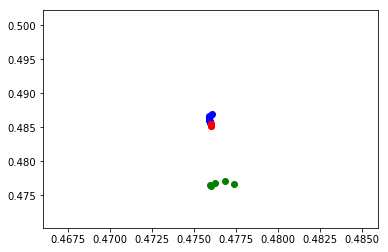

2701


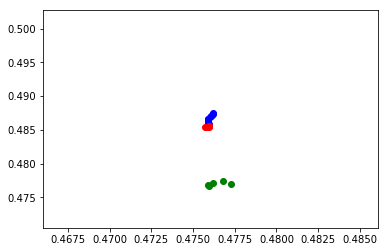

7


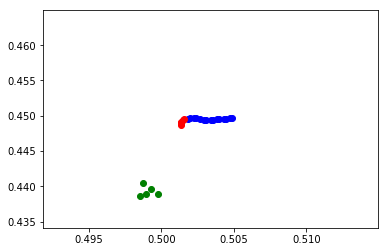

1149


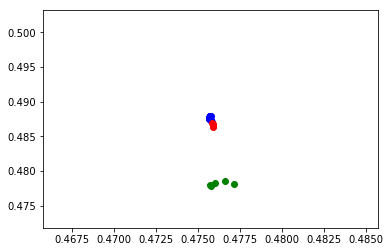

2559


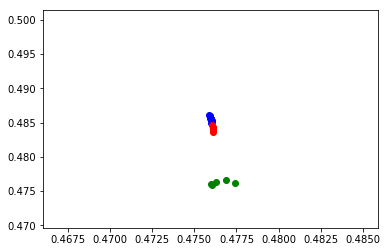

472


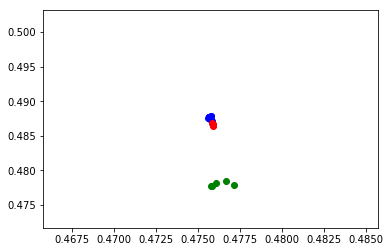

6254


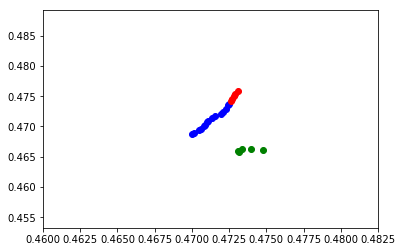

2982


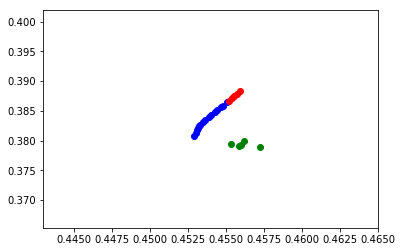

6005


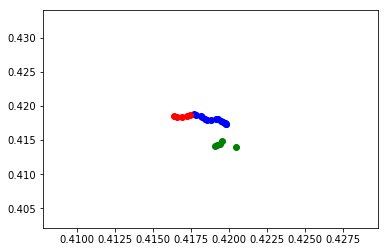

3759


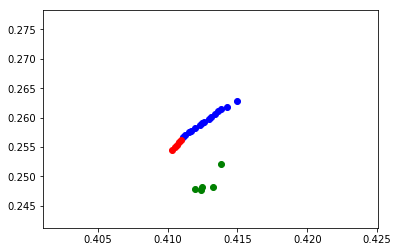

3502


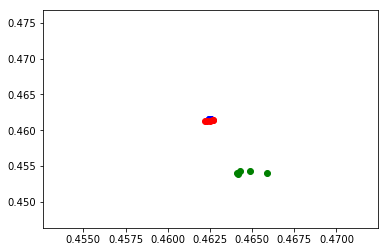

211


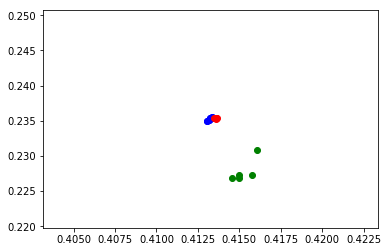

1666


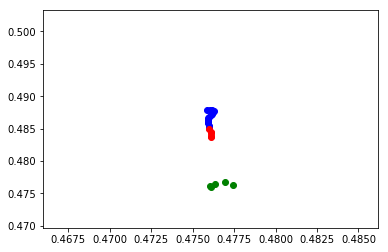

6864


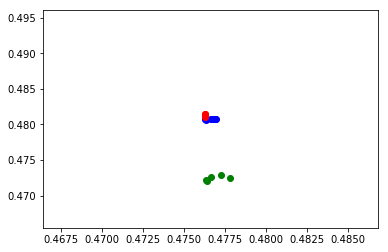

2920


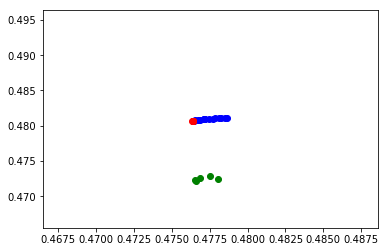

253


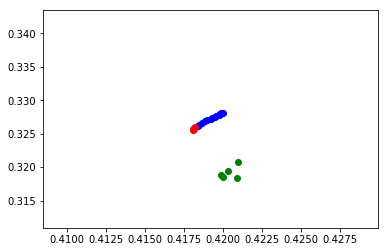

3079


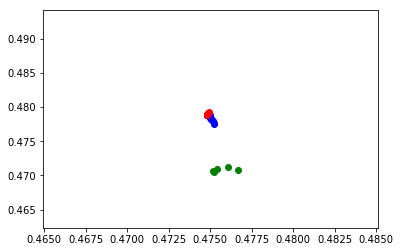

5833


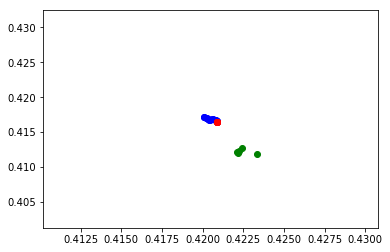

6243


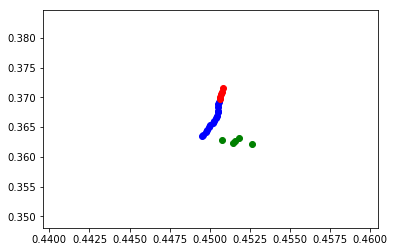

5156


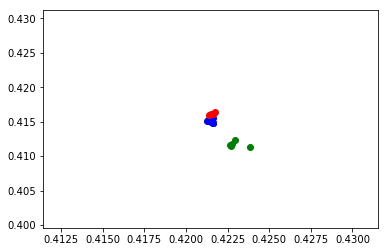

2039


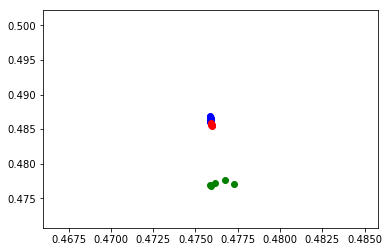

4745


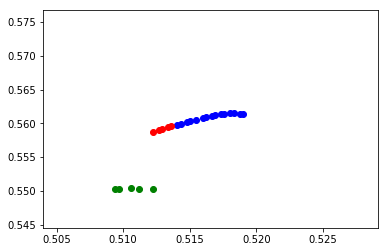

2601


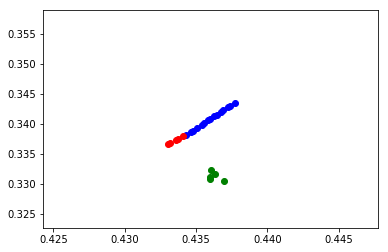

1038


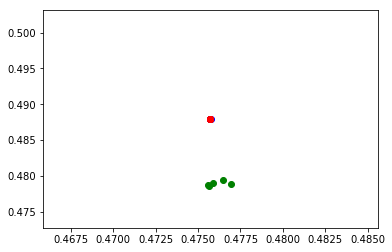

4964


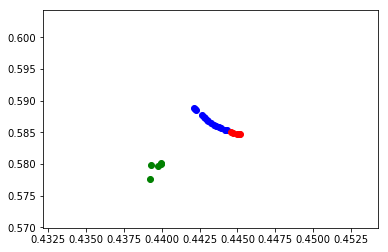

794


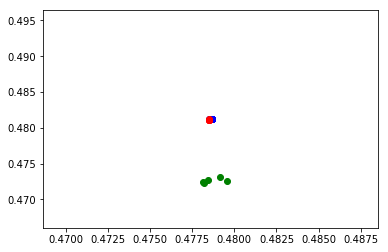

957


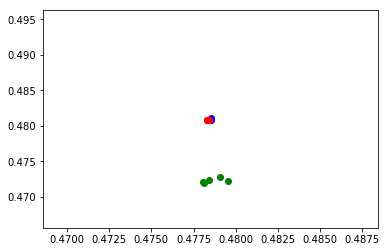

2986


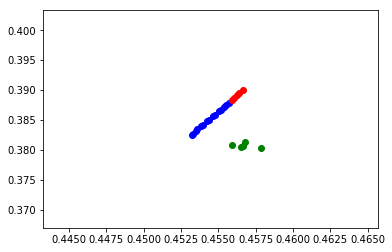

1085


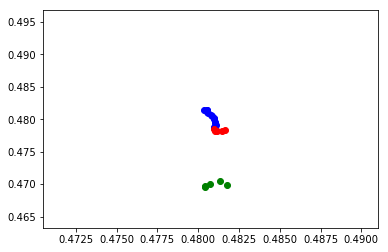

5288


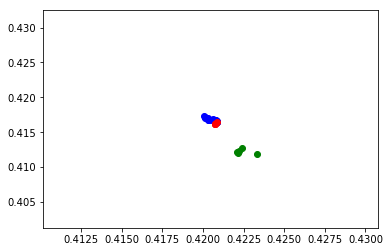

986


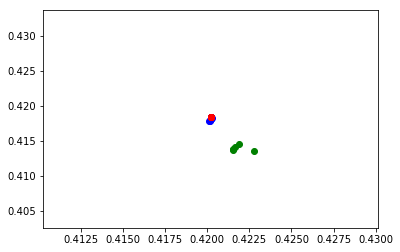

5489


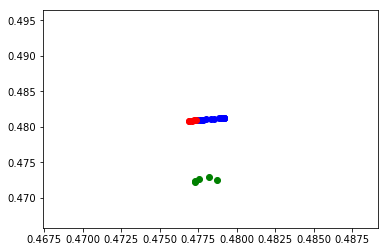

3847


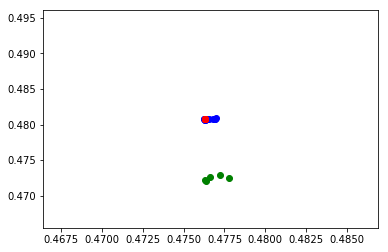

349


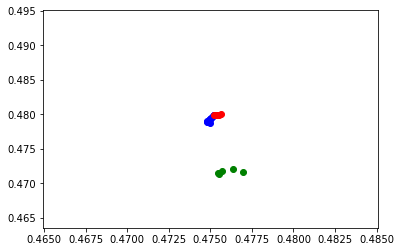

3248


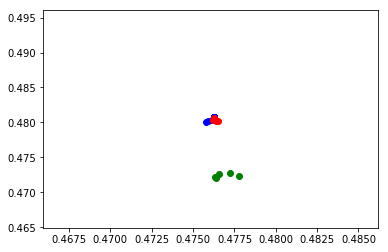

671


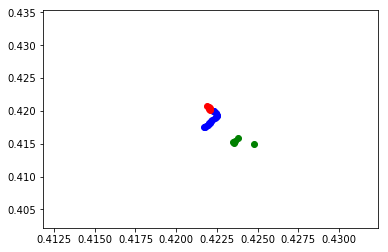

6282


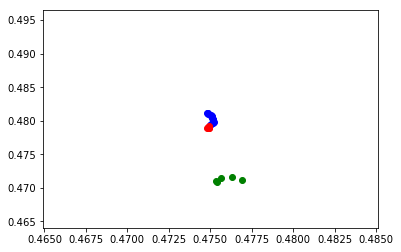

2418


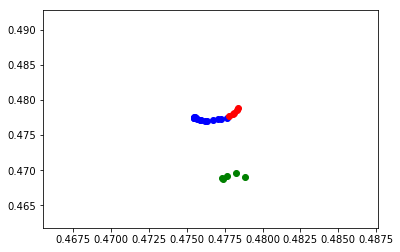

5810


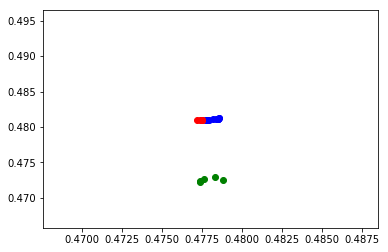

1970


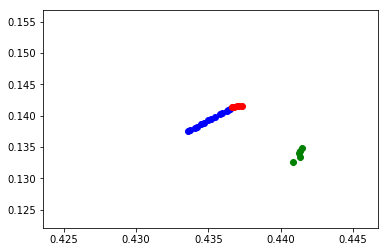

3683


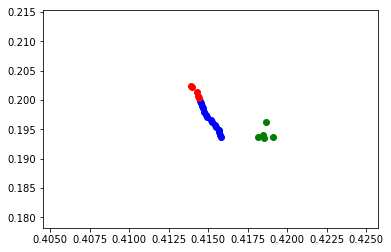

4860


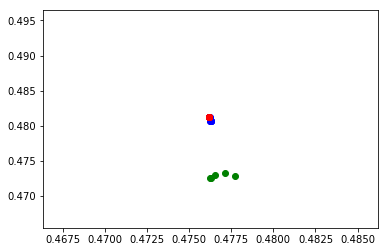

5666


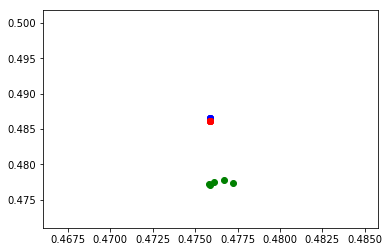

3868


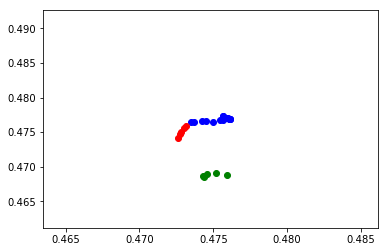

4620


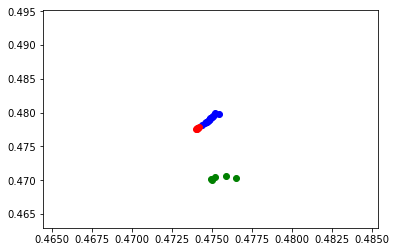

1977


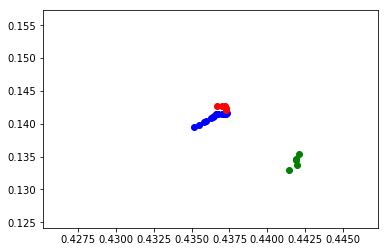

129


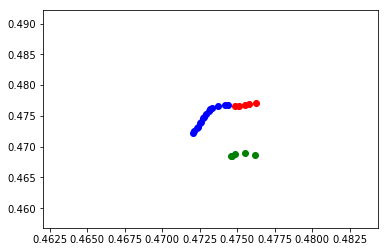

6799


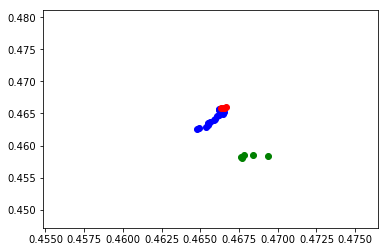

1594


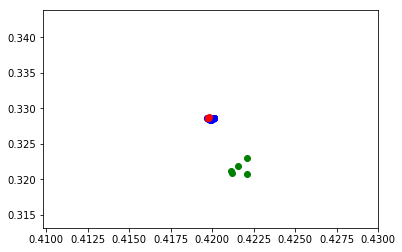

1426


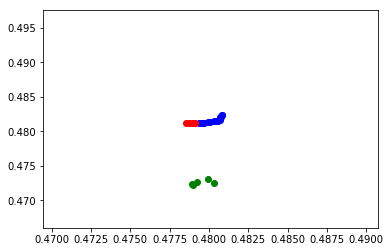

In [14]:
pred = model.predict(test_data_in)
for _ in range(50):
    i = np.random.randint(val_data_in.shape[0])
    print(i)
    plt.scatter(test_data_in[i,:,0],test_data_in[i,:,1], color='blue')
    plt.scatter(test_data_out[i,:,0],test_data_out[i,:,1], color='red')
    plt.scatter(pred[i,:,0], pred[i,:,1], color='green')
    plt.show()